# P4 - Backpropagation

In [1]:
import math
import random

def sigmoid(x):
    """
    Geeft de sigmoid van x terug
    """
    return 1 / (1 + math.exp(-x))

def calculate_gradient(output_i, delta_j):
    """
    Punt 2 van de opdracht. Bereken de gradient van de weight
    """
    return output_i * delta_j

def calculate_weight_delta(learning_rate, delta_j, bias=False, input_i=None):
    """
    Punt 3 van de opdracht. Bereken de delta van de weight
    """
    if bias:
        return learning_rate * delta_j
    else:
        return learning_rate * calculate_gradient(input_i, delta_j)
    
def test(output, target):
    """
    Test of de output overeenkomt met de target
    """
    if type(output) != list:    
        output = [output]
    if type(target) != list:
        target = [target]
    for i in range(len(output)):
        if output[i] != target[i]:
            return False
    return True

In [2]:
class Neuron():
    def __init__(self, name, weights, bias, output_neuron=False):
        self.name = name
        self.weights = [float(x) for x in weights]
        self.bias = float(bias)
        self.delta = None
        self.weight_deltas = weights
        self.bias_delta = None
        self.output_neuron = output_neuron
        self.previous_input = None

    def __str__(self):
        return f"Neuron '{self.name}' with input weights {self.weights}, bias {self.bias} and error {self.delta}."
    
    def output(self, input):
        self.previous_input = input
        if type(input) == int:
            input = [input]
        if len(input) != len(self.weights):
            raise ValueError(f"The number of inputs must be equal to the number of weights. Got {len(input)} inputs and {len(self.weights)} weights.")
        total = 0.0
        for i in range(len(input)):
            total += input[i] * self.weights[i]
        return sigmoid(total + self.bias)
    
    def calculate_deltas(self, input, learning_rate):
        for i in range(len(self.weights)):
            self.weight_deltas[i] = self.weights[i] - calculate_weight_delta(learning_rate, self.delta, input_i=input[i])
        self.bias_delta = self.bias - calculate_weight_delta(learning_rate, self.delta, bias=True)
    
    def update_error(self, input, desired=None, weights=None, deltas=None):
        output = self.output(input)
        if self.output_neuron:
            self.delta = output * (1 - output) * - (desired - output)
        else:
            self.delta = output * (1 - output) * sum([weight * delta for weight, delta in zip(weights, deltas)])
        
class NeuronLayer():
    def __init__(self, name, neurons):
        self.name = name
        self.neurons = neurons

    def __str__(self):
        return f"NeuronLayer '{self.name}' with {len(self.neurons)} neurons."

    def output(self, input):
        return [n.output(input) for n in self.neurons] if hasattr(self.neurons, '__iter__') else self.neurons.output(input)
        
class NeuronNetwork():
    def __init__(self, name, layers):
        self.name = name
        self.layers = layers

    def __str__(self):
        return f"NeuronNetwork '{self.name}' with {len(self.layers)} layers."

    def feed_forward(self, input):
        for layer in self.layers:
            # Feed forward
            input = layer.output(input)
        return input
    
    def back_propagate(self, desired, learning_rate):
        # Maak een lijst van desired/targets
        if type(desired) == int:
            desired = [desired]
        # Ik loop achterstevoren door het netwerk heen, dus ik begin bij de outputlayer
        for i in range(len(self.layers) - 1, -1, -1):
            for j in range(len(self.layers[i].neurons) - 1, -1, -1):
                cur_neuron = self.layers[i].neurons[j]
                # Eerst de output neurons, ik check voor de zekerheid of het een output neuron is en of het de laatste laag is
                if cur_neuron.output_neuron == True and i == len(self.layers) - 1:
                    output_neuron = cur_neuron
                    output_neuron.update_error(output_neuron.previous_input, desired[j])
                    output_neuron.calculate_deltas(output_neuron.previous_input, learning_rate)
                # Nu voor de hidden layers
                else:
                    weights = []
                    deltas = []
                    for neuron in self.layers[i + 1].neurons:
                        weights.append(neuron.weights[j])
                        deltas.append(neuron.delta)
                    cur_neuron.update_error(cur_neuron.previous_input, weights=weights, deltas=deltas)
                    cur_neuron.calculate_deltas(cur_neuron.previous_input, learning_rate)
        
    def update(self):
        for layer in self.layers:
            for neuron in layer.neurons:
                neuron.weights = neuron.weight_deltas
                neuron.bias = neuron.bias_delta

    def mean_squared_error(self, output, target):
        multi_output = hasattr(output, '__iter__') and hasattr(target, '__iter__')
        if multi_output:
            if len(output) != len(target):
                raise ValueError("Output and target lengths must be the same")

            total_error = 0
            for i in range(len(output)):
                total_error += (target[i] - output[i]) ** 2

            return total_error / len(output)
        else:
            return (output[0] - target) ** 2
        

    def train(self, inputs, targets, learning_rate, epochs):
        for i in range(epochs):
            total_loss = 0
            for j in range(len(inputs)):
                output = self.feed_forward(inputs[j])
                self.back_propagate(targets[j], learning_rate)
                self.update()
                loss = self.mean_squared_error(output, targets[j])
                total_loss += loss
                # Uncomment als je de netwerk per input wilt zien
                # print_network(self)
            average_loss = total_loss / len(inputs)
            print(f"Epoch {i + 1} - Loss: {average_loss}")
        return average_loss

def print_network(network):
    print(f"Network '{network.name}'")
    for layer in network.layers:
        print(f"Layer '{layer.name}'")
        for neuron in layer.neurons:
            print(neuron)
        print()


# AND

Hieronder wordt de AND geïnitialiseerd:

In [3]:
o = Neuron("Output", [random.uniform(-1, 1), random.uniform(-1, 1)], random.uniform(-1, 1), output_neuron=True)

outputlayer = NeuronLayer("OutputLayer", [o])

AND_network = NeuronNetwork("AND", [outputlayer])

Nu wordt de AND getraind.

In [4]:
AND_train = [
    ([0, 0], 0),
    ([1, 0], 0),
    ([0, 1], 0),
    ([1, 1], 1)
]

inputs = [x[0] for x in AND_train]
targets = [x[1] for x in AND_train]

loss = AND_network.train(inputs, targets, 0.01, 10000)
print("\nUiteindelijke loss / Accuracy:", loss)

Epoch 1 - Loss: 0.24556535962667184
Epoch 2 - Loss: 0.24553277662550618
Epoch 3 - Loss: 0.24550018668038368
Epoch 4 - Loss: 0.24546758969511004
Epoch 5 - Loss: 0.24543498557347077
Epoch 6 - Loss: 0.24540237421923064
Epoch 7 - Loss: 0.24536975553613305
Epoch 8 - Loss: 0.24533712942789937
Epoch 9 - Loss: 0.2453044957982291
Epoch 10 - Loss: 0.24527185455079875
Epoch 11 - Loss: 0.24523920558926177
Epoch 12 - Loss: 0.2452065488172479
Epoch 13 - Loss: 0.24517388413836275
Epoch 14 - Loss: 0.24514121145618728
Epoch 15 - Loss: 0.24510853067427746
Epoch 16 - Loss: 0.2450758416961637
Epoch 17 - Loss: 0.2450431444253504
Epoch 18 - Loss: 0.24501043876531542
Epoch 19 - Loss: 0.24497772461950978
Epoch 20 - Loss: 0.24494500189135712
Epoch 21 - Loss: 0.24491227048425318
Epoch 22 - Loss: 0.24487953030156528
Epoch 23 - Loss: 0.24484678124663217
Epoch 24 - Loss: 0.2448140232227632
Epoch 25 - Loss: 0.2447812561332381
Epoch 26 - Loss: 0.24474847988130627
Epoch 27 - Loss: 0.2447156943701868
Epoch 28 - Loss: 

Dit is de truth table van de AND gate:

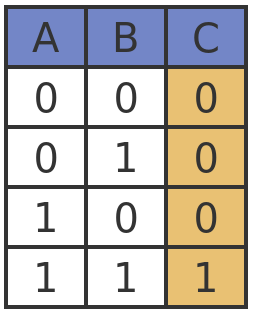

En dit zijn de uitkomsten van mijn netwerk/neuron na het trainen:

In [5]:
outputs = [AND_network.feed_forward(x) for x in inputs]

for i in range(len(outputs)):
    # Als de output groter is dan 0.5, dan is het 1, anders 0
    outputs[i] = [1 if x > 0.5 else 0 for x in outputs[i]]

print("AND\nInput, Output, Testwaarde")
for i in range(len(inputs)):
    test_value = test(outputs[i], targets[i])
    test_value = "OK" if test_value else "FAIL"
    print(inputs[i], outputs[i], test_value)


AND
Input, Output, Testwaarde
[0, 0] [0] OK
[1, 0] [0] OK
[0, 1] [0] OK
[1, 1] [1] OK


# XOR

Hieronder wordt de XOR-gate geïnitialiseerd.

In [6]:
# Hidden layer
f = Neuron("F", [random.uniform(-1, 1), random.uniform(-1, 1)], random.uniform(-1, 1))
g = Neuron("G", [random.uniform(-1, 1), random.uniform(-1, 1)], random.uniform(-1, 1))

hiddenlayer = NeuronLayer("Hidden", [f, g])

# Output layer
o = Neuron("O", [random.uniform(-1, 1), random.uniform(-1, 1)], random.uniform(-1, 1), output_neuron=True)

outputlayer = NeuronLayer("Output", [o])

xor = NeuronNetwork("XOR", [hiddenlayer, outputlayer])

Nu wordt de XOR getraind.

In [7]:
XOR_train = [
    ([1, 1], 0),
    ([0, 1], 1),
    ([1, 0], 1),
    ([0, 0], 0)
]

inputs = [x[0] for x in XOR_train]
targets = [x[1] for x in XOR_train]

loss = xor.train(inputs, targets, 0.1, 10000)
print("\nUiteindelijke loss / Accuracy:", loss)

Epoch 1 - Loss: 0.2629543744204686
Epoch 2 - Loss: 0.2621897222786352
Epoch 3 - Loss: 0.2614708974574274
Epoch 4 - Loss: 0.26079546411351295
Epoch 5 - Loss: 0.2601612559330789
Epoch 6 - Loss: 0.25956615573504305
Epoch 7 - Loss: 0.2590081025658024
Epoch 8 - Loss: 0.25848509746249376
Epoch 9 - Loss: 0.2579952079988903
Epoch 10 - Loss: 0.2575365717295418
Epoch 11 - Loss: 0.2571073986466498
Epoch 12 - Loss: 0.2567059727609935
Epoch 13 - Loss: 0.2563306529134716
Epoch 14 - Loss: 0.25597987291790236
Epoch 15 - Loss: 0.2556521411290185
Epoch 16 - Loss: 0.25534603952239465
Epoch 17 - Loss: 0.25506022236562065
Epoch 18 - Loss: 0.25479341455258564
Epoch 19 - Loss: 0.254544409665428
Epoch 20 - Loss: 0.25431206782166194
Epoch 21 - Loss: 0.25409531335729696
Epoch 22 - Loss: 0.2538931323904907
Epoch 23 - Loss: 0.2537045703044498
Epoch 24 - Loss: 0.25352872918294445
Epoch 25 - Loss: 0.25336476522692714
Epoch 26 - Loss: 0.25321188617634593
Epoch 27 - Loss: 0.253069348757295
Epoch 28 - Loss: 0.25293645

Hieronder staat de truth table van de XOR-gate:

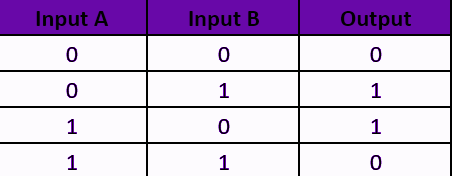

Dit zijn de daadwerkelijke uitkomsten van mijn netwerk en de tests daarvan:

In [8]:
outputs = [xor.feed_forward(x) for x in inputs]

for i in range(len(outputs)):
    # Als de output groter is dan 0.5, dan is het 1, anders 0
    outputs[i] = [1 if x > 0.5 else 0 for x in outputs[i]]

print("XOR\nInput, Output, Testwaarde")
for i in range(len(inputs)):
    test_value = test(outputs[i], targets[i])
    test_value = "OK" if test_value else "FAIL"
    print(inputs[i], outputs[i], test_value)


XOR
Input, Output, Testwaarde
[1, 1] [0] OK
[0, 1] [1] OK
[1, 0] [1] OK
[0, 0] [0] OK


# Half Adder

De half adder wordt hieronder geïnitialiseerd:

In [9]:
# Hidden layer
f = Neuron("F", [random.uniform(-1, 1), random.uniform(-1, 1)], random.uniform(-1, 1))
g = Neuron("G", [random.uniform(-1, 1), random.uniform(-1, 1)], random.uniform(-1, 1))

hiddenlayer = NeuronLayer("Hidden", [f, g])

# Output layer
o1 = Neuron("Output 1", [random.uniform(-1, 1), random.uniform(-1, 1)], random.uniform(-1, 1), output_neuron=True)
o2 = Neuron("Output 2", [random.uniform(-1, 1), random.uniform(-1, 1)], random.uniform(-1, 1), output_neuron=True)

outputlayer = NeuronLayer("Output", [o1, o2])

halfadder = NeuronNetwork("Half Adder", [hiddenlayer, outputlayer])

In deze cel wordt de half adder getraind.

In [10]:
halfadder_train = [
    ([0, 0], [0, 0]),
    ([0, 1], [1, 0]),
    ([1, 0], [1, 0]),
    ([1, 1], [0, 1])
]

inputs = [x[0] for x in halfadder_train]
targets = [x[1] for x in halfadder_train]

loss = halfadder.train(inputs, targets, 0.1, 10000)
print("\nUiteindelijke loss / Accuracy:", loss)

Epoch 1 - Loss: 0.2525729873698659
Epoch 2 - Loss: 0.25032017863101297
Epoch 3 - Loss: 0.2482200401459102
Epoch 4 - Loss: 0.2462632658549902
Epoch 5 - Loss: 0.24444082651930676
Epoch 6 - Loss: 0.24274401145796298
Epoch 7 - Loss: 0.2411644763139762
Epoch 8 - Loss: 0.2396942749143561
Epoch 9 - Loss: 0.23832587804330227
Epoch 10 - Loss: 0.23705218166361341
Epoch 11 - Loss: 0.23586650680888904
Epoch 12 - Loss: 0.2347625930538036
Epoch 13 - Loss: 0.23373458716883544
Epoch 14 - Loss: 0.23277702828970703
Epoch 15 - Loss: 0.23188483068577373
Epoch 16 - Loss: 0.23105326499747664
Epoch 17 - Loss: 0.23027793863015583
Epoch 18 - Loss: 0.22955477583797448
Epoch 19 - Loss: 0.2288799979045788
Epoch 20 - Loss: 0.2282501037232374
Epoch 21 - Loss: 0.2276618509953543
Epoch 22 - Loss: 0.2271122381993661
Epoch 23 - Loss: 0.22659848742933325
Epoch 24 - Loss: 0.22611802816153764
Epoch 25 - Loss: 0.22566848197595119
Epoch 26 - Loss: 0.22524764823571863
Epoch 27 - Loss: 0.22485349071025743
Epoch 28 - Loss: 0.2

Hieronder staat de truth table van de half adder.

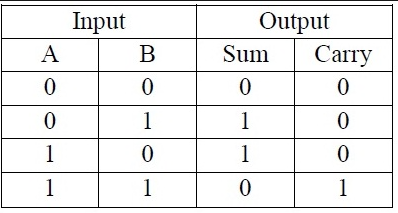

Hieronder staan de resultaten van de tests van mijn getrainde half adder.

In [11]:
outputs = [halfadder.feed_forward([0, 0]), halfadder.feed_forward([0, 1]), halfadder.feed_forward([1, 0]), halfadder.feed_forward([1, 1])]

for i in range(len(outputs)):
    # Als de output groter is dan 0.5, dan is het 1, anders 0
    outputs[i] = [1 if x > 0.5 else 0 for x in outputs[i]]

print("Half Adder\nInput, Output, Testwaarde")
for i in range(len(halfadder_train)):
    test_value = test(outputs[i], halfadder_train[i][1])
    test_value = "OK" if test_value else "FAIL"
    print(halfadder_train[i][0], outputs[i], test_value)


Half Adder
Input, Output, Testwaarde
[0, 0] [0, 0] OK
[0, 1] [1, 0] OK
[1, 0] [1, 0] OK
[1, 1] [0, 1] OK


# IRIS-dataset

Ik richt mijn neurale netwerk in met 2 hidden layers voor deze dataset. Eerste layer heeft 16 neurons, de tweede 8. De output layer heeft natuurlijk 3 outputs voor de verschillende planten.

In [12]:
# Hidden layer 1
neurons_hidden1 = []
for i in range(16):
    neurons_hidden1.append(Neuron(f"Neuron {i}", [random.uniform(-1, 1), random.uniform(-1, 1), random.uniform(-1, 1), random.uniform(-1, 1)], random.uniform(-1, 1)))

hiddenlayer1 = NeuronLayer("Hidden Layer 1", neurons_hidden1)

# Hidden layer 2
neurons_hidden2 = []
for i in range(8):
    neurons_hidden2.append(Neuron(f"Neuron {i}", [random.uniform(-1, 1) for _ in range(16)], random.uniform(-1, 1)))

hiddenlayer2 = NeuronLayer("Hidden Layer 2", neurons_hidden2)

# Output layer
neurons_output = []
for i in range(3):
    neurons_output.append(Neuron(f"Neuron {i}", [random.uniform(-1, 1) for _ in range(8)], random.uniform(-1, 1), output_neuron=True))

outputlayer = NeuronLayer("Output", neurons_output)

iris = NeuronNetwork("Iris", [hiddenlayer1, hiddenlayer2, outputlayer])

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris_X, iris_y = load_iris(return_X_y=True)

# Transform the target numbers to a list representing the target number
# 0 -> [1, 0, 0] (Iris Setosa)
# 1 -> [0, 1, 0] (Iris Versicolour)
# 2 -> [0, 0, 1] (Iris Virginica)
iris_y = [[1, 0, 0] if x == 0 else [0, 1, 0] if x == 1 else [0, 0, 1] for x in iris_y]

iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y, test_size=0.2)

loss = iris.train(iris_X_train, iris_y_train, 0.01, 500)
print("\nUiteindelijke loss / Accuracy:", loss)

Epoch 1 - Loss: 0.28169995016726174
Epoch 2 - Loss: 0.25013411926448115
Epoch 3 - Loss: 0.23365991552213197
Epoch 4 - Loss: 0.2259087371690169
Epoch 5 - Loss: 0.22218829752934344
Epoch 6 - Loss: 0.22023852253278062
Epoch 7 - Loss: 0.21907996386355144
Epoch 8 - Loss: 0.21828629064887542
Epoch 9 - Loss: 0.21766501601342123
Epoch 10 - Loss: 0.2171253442959453
Epoch 11 - Loss: 0.21662241002600321
Epoch 12 - Loss: 0.21613284632078705
Epoch 13 - Loss: 0.2156436712000155
Epoch 14 - Loss: 0.21514707259159882
Epoch 15 - Loss: 0.21463790760458926
Epoch 16 - Loss: 0.21411249271086893
Epoch 17 - Loss: 0.21356802400084093
Epoch 18 - Loss: 0.2130023083419032
Epoch 19 - Loss: 0.21241364357535206
Epoch 20 - Loss: 0.2118007608162917
Epoch 21 - Loss: 0.21116278096908084
Epoch 22 - Loss: 0.2104991624626728
Epoch 23 - Loss: 0.2098096365817731
Epoch 24 - Loss: 0.20909414102583387
Epoch 25 - Loss: 0.20835276763758542
Epoch 26 - Loss: 0.20758573378076625
Epoch 27 - Loss: 0.20679337160878605
Epoch 28 - Loss: 

In [14]:
outputs = [iris.feed_forward(x) for x in iris_X_test]

for i in range(len(outputs)):
    # Als de output groter is dan 0.5, dan is het 1, anders 0
    outputs[i] = [1 if x > 0.5 else 0 for x in outputs[i]]

print("Iris\nInput, Output, Testwaarde")
for i in range(len(iris_X_test)):
    test_value = test(outputs[i], iris_y_test[i])
    test_value = "OK" if test_value else "FAIL"
    print(iris_X_test[i], outputs[i], test_value)

Iris
Input, Output, Testwaarde
[4.6 3.4 1.4 0.3] [1, 0, 0] OK
[6.8 3.  5.5 2.1] [0, 0, 1] OK
[5.8 2.7 5.1 1.9] [0, 0, 1] OK
[6.6 3.  4.4 1.4] [0, 1, 0] OK
[7.2 3.6 6.1 2.5] [0, 0, 1] OK
[6.6 2.9 4.6 1.3] [0, 1, 0] OK
[6.8 2.8 4.8 1.4] [0, 1, 0] OK
[5.8 4.  1.2 0.2] [1, 0, 0] OK
[7.2 3.  5.8 1.6] [0, 0, 1] OK
[4.7 3.2 1.3 0.2] [1, 0, 0] OK
[4.3 3.  1.1 0.1] [1, 0, 0] OK
[6.4 2.8 5.6 2.2] [0, 0, 1] OK
[5.5 4.2 1.4 0.2] [1, 0, 0] OK
[5.  3.4 1.6 0.4] [1, 0, 0] OK
[5.1 3.5 1.4 0.2] [1, 0, 0] OK
[5.1 3.3 1.7 0.5] [1, 0, 0] OK
[5.  2.3 3.3 1. ] [0, 1, 0] OK
[4.6 3.6 1.  0.2] [1, 0, 0] OK
[5.3 3.7 1.5 0.2] [1, 0, 0] OK
[6.3 3.3 6.  2.5] [0, 0, 1] OK
[6.1 2.8 4.  1.3] [0, 1, 0] OK
[6.5 3.  5.5 1.8] [0, 0, 1] OK
[5.7 3.  4.2 1.2] [0, 1, 0] OK
[6.5 2.8 4.6 1.5] [0, 1, 0] OK
[5.4 3.7 1.5 0.2] [1, 0, 0] OK
[5.8 2.7 5.1 1.9] [0, 0, 1] OK
[6.  2.2 4.  1. ] [0, 1, 0] OK
[5.  3.2 1.2 0.2] [1, 0, 0] OK
[4.9 3.1 1.5 0.2] [1, 0, 0] OK
[4.8 3.1 1.6 0.2] [1, 0, 0] OK


# Digit Dataset

In [15]:
# Hidden layer 1
neurons_hidden1 = []
for i in range(32):
    neurons_hidden1.append(Neuron(f"Neuron {i}", [random.uniform(-1, 1) for _ in range(64)], random.uniform(-1, 1)))
hiddenlayer1 = NeuronLayer("Hidden Layer 1", neurons_hidden1)

# Hidden layer 2
neurons_hidden2 = []
for i in range(16):
    neurons_hidden2.append(Neuron(f"Neuron {i}", [random.uniform(-1, 1) for _ in range(32)], random.uniform(-1, 1)))
hiddenlayer2 = NeuronLayer("Hidden Layer 2", neurons_hidden2)

# Output layer
neurons_output = []
for i in range(10):
    neurons_output.append(Neuron(f"Neuron {i}", [random.uniform(-1, 1) for _ in range(16)], random.uniform(-1, 1), output_neuron=True))

outputlayer = NeuronLayer("Output", neurons_output)

digits = NeuronNetwork("Digit", [hiddenlayer1, hiddenlayer2, outputlayer])

In [16]:
from sklearn.datasets import load_digits
digits_X, digits_y = load_digits(return_X_y=True)


# Transform the target numbers to a list representing the target number
digits_y = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0] if x == 0 else
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] if x == 1 else
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] if x == 2 else
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] if x == 3 else
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] if x == 4 else
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] if x == 5 else
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] if x == 6 else
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0] if x == 7 else
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0] if x == 8 else
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] for x in digits_y]

digits_X_train, digits_X_test, digits_y_train, digits_y_test = train_test_split(digits_X, digits_y, test_size=0.2)

import time
start = time.time()
loss = digits.train(digits_X_train, digits_y_train, 0.1, 10)
end = time.time()
print("\nUiteindelijke loss / Accuracy:", loss)

Epoch 1 - Loss: 0.08663644221559895
Epoch 2 - Loss: 0.06819868077615956
Epoch 3 - Loss: 0.05320163343963474
Epoch 4 - Loss: 0.04196605621503918
Epoch 5 - Loss: 0.03250931826271055
Epoch 6 - Loss: 0.025507507390201432
Epoch 7 - Loss: 0.02164373320206278
Epoch 8 - Loss: 0.017993645764175812
Epoch 9 - Loss: 0.01589522014979369
Epoch 10 - Loss: 0.012986527100495249

Uiteindelijke loss / Accuracy: 0.012986527100495249


In [17]:
outputs = [digits.feed_forward(x) for x in digits_X_test]

for i in range(len(outputs)):
    # Als de output groter is dan 0.5, dan is het 1, anders 0
    outputs[i] = [1 if x > 0.5 else 0 for x in outputs[i]]

print("Testiteratie, Testwaarde")
for i in range(len(digits_X_test)):
    test_value = test(outputs[i], digits_y_test[i])
    test_value = "OK" if test_value else "FAIL"
    print(i, test_value)

Testiteratie, Testwaarde
0 OK
1 OK
2 FAIL
3 OK
4 OK
5 OK
6 FAIL
7 OK
8 OK
9 OK
10 OK
11 OK
12 OK
13 OK
14 OK
15 FAIL
16 OK
17 OK
18 OK
19 OK
20 OK
21 OK
22 OK
23 OK
24 OK
25 OK
26 OK
27 OK
28 OK
29 OK
30 FAIL
31 OK
32 OK
33 FAIL
34 OK
35 OK
36 OK
37 FAIL
38 FAIL
39 OK
40 OK
41 OK
42 OK
43 OK
44 OK
45 OK
46 OK
47 OK
48 OK
49 OK
50 OK
51 OK
52 OK
53 OK
54 OK
55 OK
56 OK
57 OK
58 OK
59 OK
60 OK
61 OK
62 OK
63 FAIL
64 OK
65 OK
66 OK
67 OK
68 OK
69 FAIL
70 OK
71 FAIL
72 FAIL
73 OK
74 OK
75 OK
76 OK
77 OK
78 OK
79 OK
80 OK
81 OK
82 OK
83 OK
84 OK
85 OK
86 OK
87 OK
88 OK
89 OK
90 OK
91 OK
92 OK
93 OK
94 OK
95 OK
96 OK
97 OK
98 OK
99 OK
100 OK
101 OK
102 OK
103 OK
104 OK
105 OK
106 OK
107 OK
108 OK
109 OK
110 OK
111 OK
112 OK
113 OK
114 OK
115 OK
116 FAIL
117 OK
118 OK
119 OK
120 OK
121 OK
122 OK
123 OK
124 OK
125 OK
126 OK
127 OK
128 OK
129 OK
130 OK
131 OK
132 OK
133 FAIL
134 OK
135 OK
136 OK
137 OK
138 OK
139 OK
140 OK
141 OK
142 OK
143 OK
144 OK
145 OK
146 OK
147 OK
148 OK
149 OK
150 FAIL


### Wat waren de hyperparameters van je netwerk en hoeveel tijd kostte het om je netwerk te trainen?
Met een learning rate van 0.1 en 10 epochs kost het zoveel tijd:

In [18]:
print(f"Training duurde {(end - start):.2f} seconden.")

Training duurde 29.21 seconden.
